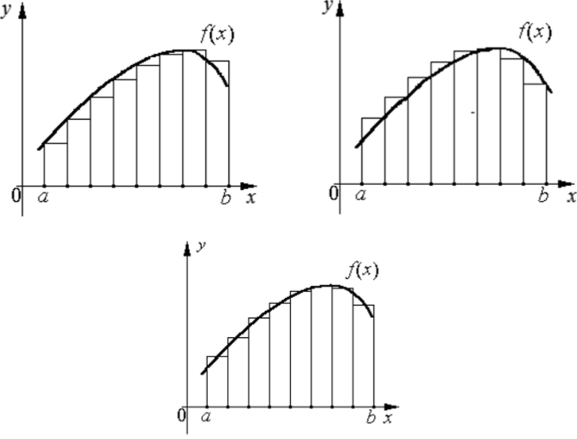

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from matplotlib.colors import Normalize
from scipy import stats as sps

import pandas as pd

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def left_rect(foo, a, b, N):
    xn, h = np.linspace(a, b, N + 1, retstep=True)
    vals = foo(xn[:-1])
    return vals.sum() * h


def right_rect(foo, a, b, N):
    xn, h = np.linspace(a, b, N + 1, retstep=True)
    vals = foo(xn[1:])
    return vals.sum() * h


def mid_rect(foo, a, b, N):
    xn, h = np.linspace(a, b, N + 1, retstep=True)
    vals = foo(xn[:-1] + 0.5 * h)
    return vals.sum() * h


def trapz(foo, a, b, N):
    xn, h = np.linspace(a, b, N + 1, retstep=True)
    vals = foo(xn)
    return vals.sum() * h - 0.5 * h * (vals[0] + vals[-1])


def simpson(foo, a, b, N):
    if N % 2 != 0:
        N += 1
    
    xn, h = np.linspace(a, b, N + 1, retstep=True)
    vals = foo(xn)
    
    # Сумма с весами 1-4-2-4-2-...-4-1
    result = vals[0] + vals[-1]  # первое и последнее значение с весом 1
    result += 4 * np.sum(vals[1:-1:2])  # нечетные индексы с весом 4
    result += 2 * np.sum(vals[2:-1:2])  # четные индексы с весом 2
    
    return result * h / 3

In [3]:
foo = np.exp
Foo = np.exp

a = 1
b = 5
I = Foo(b) - Foo(a)

In [4]:
from collections import defaultdict
from tqdm.notebook import tqdm

In [5]:
quadratures = {"left" : left_rect, "right" : right_rect, "mid" : mid_rect, 
        "trapz" : trapz, "simpson" : simpson}
results = defaultdict(list)

Ns = 2 ** np.arange(5, 20)

for name, quad in quadratures.items():
    for N in tqdm(Ns):
        results[name].append(quad(foo, a, b, N))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Alex\AppData\Local\Temp\ipykernel_14696\1352069002.py:4: RuntimeWarning: divide by zero encountered in log
  x, y = np.log(Ns), np.log(error)


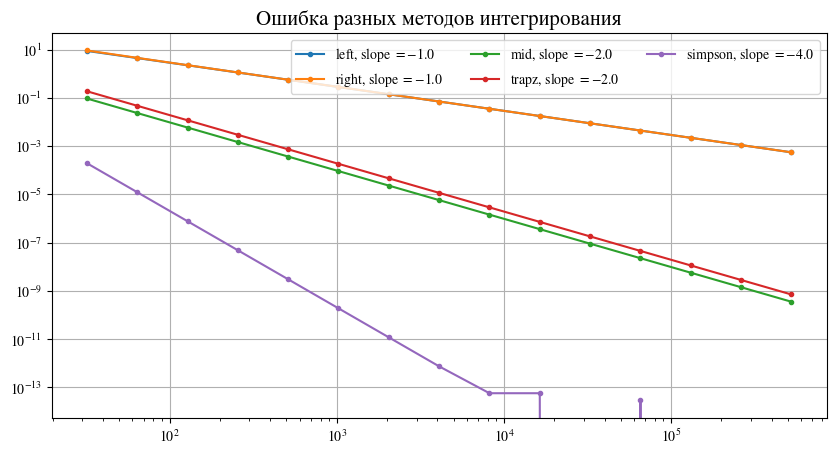

In [6]:
plt.figure(figsize=(10, 5))
for i, name in enumerate(quadratures.keys()):
    error = np.abs(results[name] - I)
    x, y = np.log(Ns), np.log(error)
    mask = error > 1e-13
    scale, loc = np.polyfit(x[mask], y[mask], 1)
    plt.loglog(Ns, error, '-o', ms=3, label=fr'{name}, slope $={scale:0.1f}$', color=f'C{i}')
    #plt.loglog(Ns[mask], np.exp(loc + scale * x[mask]), '--', color=f'C{i}')
plt.title("Ошибка разных методов интегрирования", fontsize=15)
plt.legend(fontsize=10, ncol=3)
plt.grid()
plt.show()

## Апостериорная оценка точности

Как оценить ошибку, если мы не знаем точное решение? **Апостериорная оценка точности**

* Хотим оценить ошибку, не зная точного решения
* Ошибка имеет степенную зависимость от шага сетки $h = \dfrac{1}{N}$
$$
    I_N = I + R_N = I + c \cdot h^{p}
$$где $R_N$ -- ошибка на $N$ узлах, $c\in \mathbb{R}$ -- константа, $p$ -- порядок метода.
* Оценка интеграла на сгущённой сетке:
$$
    I_{2N} = I + R_{2N} = I + \dfrac{c}{2^p} \cdot h^p
$$
* Вычтем второе уравнение из первого, получим:
$$
    I_{2N} - I_N = \dfrac{c}{2^p} \cdot h^p - c \cdot h^{p} = R_{2N}(1 - 2^p)
$$откуда оценка ошибки: 
$$
    \hat{R}_{2N} = \dfrac{I_N - I_{2N}}{2^p - 1}, \quad \hat{R}_N = \hat{R}_{2N} \cdot 2^p
$$

In [7]:
def richardson_iteration(Ns, I, p):
    I = np.array(I)
    # оценка ошибки
    R = np.zeros(len(Ns))
    # формула Ричардсона
    R[1:] = (I[:-1] - I[1:]) / (2 ** p - 1)
    # экстраполяция ошибки R_N
    R[0] = R[1] * (2 ** p)
    return R

In [8]:
# параметры моделей
# исходный порядок метода
ps = {"left" : 1, "right" : 1, "mid" : 2, 
        "trapz" : 2, "simpson" : 4}

apost_errors = {
    name : richardson_iteration(Ns, results[name], ps[name]) for name in results
}
apost_errors = pd.DataFrame(apost_errors, index=Ns)

true_errors = {
    name : results[name] - I for name in results
}
true_errors = pd.DataFrame(true_errors, index=Ns)

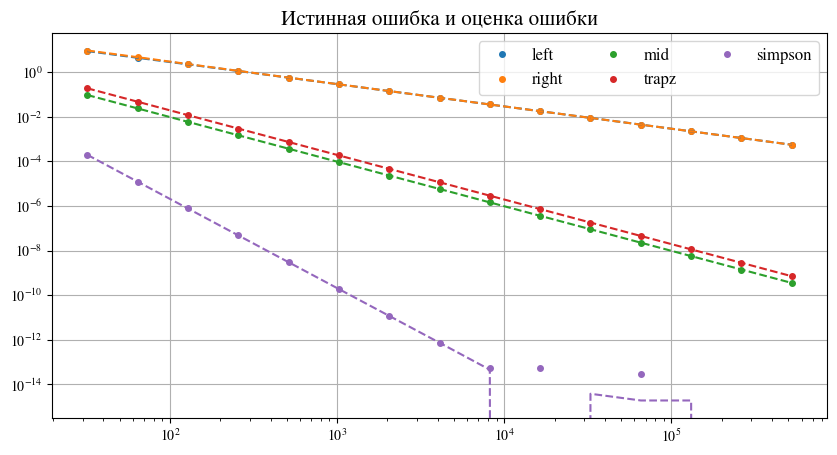

In [9]:
plt.figure(figsize=(10, 5))
plt.loglog(true_errors.abs(), 'o', ms=4)
plt.gca().set_prop_cycle(None)
plt.loglog(apost_errors.abs(), '--')
plt.legend(true_errors.columns, fontsize=12, ncol=3)
plt.title("Истинная ошибка и оценка ошибки", fontsize=15)
plt.grid()
plt.show()

## Итерационное улучшение точности

* Зная оценку ошибки $\hat{R}_N$ можем получить более точную оценку для интеграла:
$$
    \hat{I}_N = I_N - \hat{R}_N 
$$
* Ошибка $\hat{I}_N$ имеет более высокий порядок чем $p$. Для несимметричных схем:
$$
    \hat{I}_N = I_N - \hat{R}_N = I + c' h^{p+1}
$$
* Для симметричных схем (ошибка расскладывается по чётным степеням $h$:
$$
    \hat{I}_N = I_N - \hat{R}_N = I + c' h^{p+2}
$$
* Улучшение точности можно проделывать много раз

In [10]:
def richardrson(Ns, I, p, inc=1, niter=None):
    # число итераций метода Ричарсдона
    if niter is None:
        niter = len(Ns) - 1
    # оценки интегралов
    integrals = [I]
    # оценки ошибок
    errors = []
    for i in range(niter):
        # оценка ошибки предыдущего интеграла (I)
        R = richardson_iteration(Ns, I, p + i * inc)
        # новое значение интеграла Inew = I - R
        I = I - R
        # сохраняем данные
        integrals.append(I)
        errors.append(R)
    return np.array(integrals), np.array(errors)

In [11]:
# на сколько увеличивается точность на каждой итерации метода Ричардсона
# 1 для несимметричных схем, 2 для симметричных
incs = {"left" : 1, "right" : 1, "mid" : 2, 
        "trapz" : 2, "simpson" : 2}
# результаты
richs = {name : richardrson(Ns, results[name], ps[name], incs[name], niter=4) for name in results}

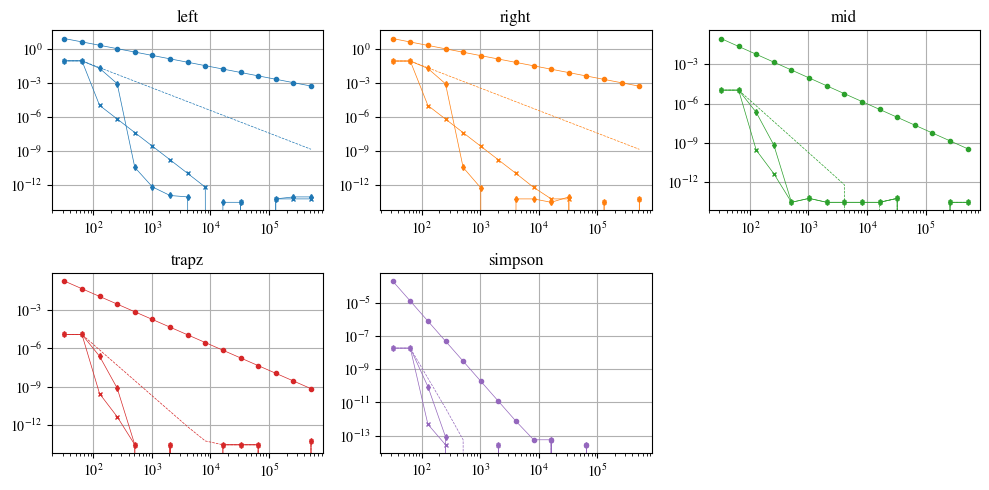

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
ax = ax.reshape(-1)
for i, name in enumerate(richs.keys()):
    integrals = richs[name][0]
    true_error = np.abs(integrals - I)
    ax[i].loglog(Ns, true_error[0].T, '-o', ms=3, lw=0.5, color=f'C{i}')
    ax[i].loglog(Ns, true_error[1].T, '--', ms=3, lw=0.5, color=f'C{i}')
    ax[i].loglog(Ns, true_error[2].T, '-x', ms=3, lw=0.5, color=f'C{i}')
    ax[i].loglog(Ns, true_error[4].T, '-d', ms=3, lw=0.5, color=f'C{i}')
    ax[i].grid()
    ax[i].set_title(name)
for j in range(i + 1, 6):
    ax[j].remove()
fig.tight_layout()
plt.show()

## Что будет с негладкими функциям?

In [13]:
alpha = 0.5
foo = lambda x: x ** alpha
Foo = lambda x: (x ** alpha) / (1 + alpha)

a = 0
b = 1
I = Foo(b) - Foo(a)

results = defaultdict(list)
Ns = 2 ** np.arange(5, 20)
for name, quad in quadratures.items():
    for N in tqdm(Ns):
        results[name].append(quad(foo, a, b, N))
    results[name] = np.array(results[name])    

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

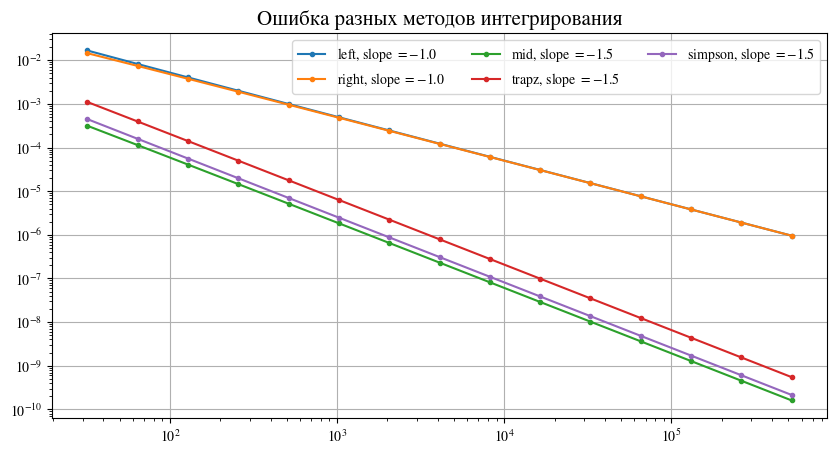

In [14]:
plt.figure(figsize=(10, 5))
for i, name in enumerate(quadratures.keys()):
    error = np.abs(results[name] - I)
    x, y = np.log(Ns), np.log(error)
    mask = error > 1e-13
    scale, loc = np.polyfit(x[mask], y[mask], 1)
    plt.loglog(Ns, error, '-o', ms=3, label=fr'{name}, slope $={scale:0.1f}$', color=f'C{i}')
plt.title("Ошибка разных методов интегрирования", fontsize=15)
plt.legend(fontsize=10, ncol=3)
plt.grid()
plt.show()

## Что будет с периодическими функциями?

In [20]:
foo = lambda x: np.sin(x)
Foo = lambda x: -np.cos(x)

a = 0
b = 2 * np.pi / 2
I = Foo(b) - Foo(a)

results = defaultdict(list)
Ns = 2 ** np.arange(5, 20)
for name, quad in quadratures.items():
    for N in tqdm(Ns):
        results[name].append(quad(foo, a, b, N))
    results[name] = np.array(results[name])    

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

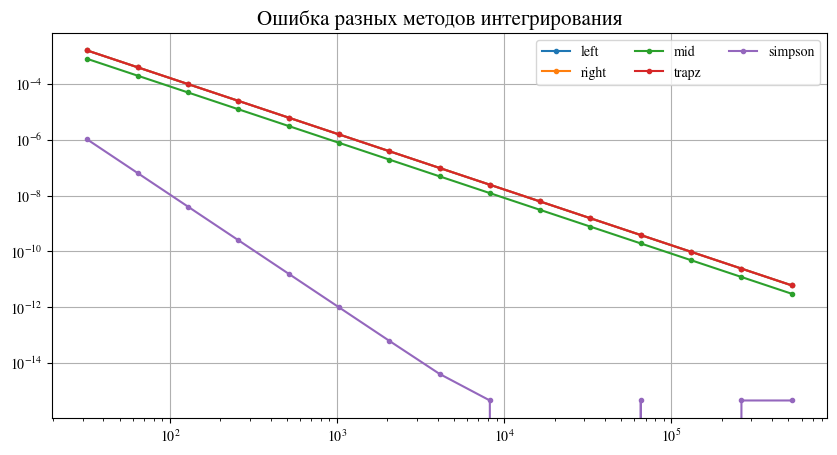

In [21]:
plt.figure(figsize=(10, 5))
for i, name in enumerate(quadratures.keys()):
    error = np.abs(results[name] - I)
    #x, y = np.log(Ns), np.log(error)
    #mask = error > 1e-13
    #scale, loc = np.polyfit(x[mask], y[mask], 1)
    plt.loglog(Ns, error, '-o', ms=3, label=fr'{name}', color=f'C{i}')
plt.title("Ошибка разных методов интегрирования", fontsize=15)
plt.legend(fontsize=10, ncol=3)
plt.grid()
plt.show()

In [22]:
pd.DataFrame(results) - I

,left,right,mid,trapz,simpson
0,-1.606639e-03,-1.606639e-03,8.034163e-04,-1.606639e-03,1.033369e-06
1,-4.016114e-04,-4.016114e-04,2.008117e-04,-4.016114e-04,6.453000e-08
2,-1.003998e-04,-1.003998e-04,5.020029e-05,-1.003998e-04,4.032257e-09
3,-2.509976e-05,-2.509976e-05,1.254991e-05,-2.509976e-05,2.520024e-10
4,-6.274929e-06,-6.274929e-06,3.137466e-06,-6.274929e-06,1.575007e-11
5,-1.568732e-06,-1.568732e-06,7.843659e-07,-1.568732e-06,9.841017e-13
6,-3.921829e-07,-3.921829e-07,1.960914e-07,-3.921829e-07,6.172840e-14
7,-9.804571e-08,-9.804571e-08,4.902286e-08,-9.804571e-08,3.996803e-15
8,-2.451143e-08,-2.451143e-08,1.225571e-08,-2.451143e-08,4.440892e-16
9,-6.127857e-09,-6.127857e-09,3.063929e-09,-6.127857e-09,0.000000e+00
